# Reinforcement Learning: Snake mit Deep Q-Network (DQN)
Dieses Notebook zeigt die Anwendung von DQN auf das Snake-Spiel mit erweiterten Zustandsmerkmalen.

In [1]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pygame

pygame 2.6.1 (SDL 2.28.4, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Python312\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## 🐍 Snake-Umgebung
Enthält Spiellogik, Zustandsberechnung und Rendering mit Pygame.

In [2]:
import pygame
import random
import numpy as np

# Spielfeldkonfiguration
BLOCK_SIZE = 20
GRID_SIZE = 20
WIDTH = HEIGHT = BLOCK_SIZE * GRID_SIZE

# Farben für Anzeige
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED   = (255, 0, 0)
BLACK = (0, 0, 0)

class SnakeGame:
    def __init__(self):
        # Initialisierung der Anzeige
        pygame.init()
        self.display = pygame.display.set_mode((WIDTH, HEIGHT))
        pygame.display.set_caption("Snake")
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self):
        # Schlange startet mittig mit drei Segmenten nach links
        self.direction = (1, 0)
        self.head = [GRID_SIZE // 2, GRID_SIZE // 2]
        self.snake = [self.head[:], [self.head[0] - 1, self.head[1]], [self.head[0] - 2, self.head[1]]]
        self.score = 0
        self.food = self.place_food()
        self.frame_iteration = 0
        return self.get_state()

    def place_food(self):
        # Apfel an zufälliger, freier Position platzieren
        while True:
            x = random.randint(0, GRID_SIZE - 1)
            y = random.randint(0, GRID_SIZE - 1)
            if [x, y] not in self.snake:
                return [x, y]

    def step(self, action):
        self.frame_iteration += 1

        # Richtungsänderung auf Basis der Aktion
        clock_wise = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        idx = clock_wise.index(self.direction)

        if action == 0:  # geradeaus
            new_dir = self.direction
        elif action == 1:  # rechts drehen
            new_dir = clock_wise[(idx + 1) % 4]
        else:  # links drehen
            new_dir = clock_wise[(idx - 1) % 4]

        self.direction = new_dir

        # Neue Kopfposition berechnen
        x, y = self.head
        dx, dy = self.direction
        self.head = [x + dx, y + dy]
        self.snake.insert(0, self.head[:])

        reward = -0.05  # Grundstrafe für jeden Schritt
        done = False

        # Apfel gefressen?
        ate_food = self.head == self.food
        if ate_food:
            self.score += 1
            reward = 1.0
            self.food = self.place_food()
        else:
            self.snake.pop()  # sonst: Schlange bewegt sich weiter

        # Kollision mit Wand oder sich selbst
        if (self.head in self.snake[1:] or
            self.head[0] < 0 or self.head[0] >= GRID_SIZE or
            self.head[1] < 0 or self.head[1] >= GRID_SIZE):
            done = True
            reward = -1.0
            return self.get_state(), reward, done, {}

        # Bonus/Penalty je nachdem, ob man dem Apfel näherkommt
        old_dist = np.linalg.norm(np.array(self.snake[1]) - np.array(self.food))
        new_dist = np.linalg.norm(np.array(self.head) - np.array(self.food))
        if new_dist < old_dist:
            reward += 0.1
        else:
            reward -= 0.1

        # Freiraum vor der Schlange abschätzen
        def free_space(direction, max_depth=4):
            x, y = self.head
            dx, dy = direction
            count = 0
            for i in range(1, max_depth + 1):
                nx, ny = x + dx * i, y + dy * i
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and [nx, ny] not in self.snake:
                    count += 1
                else:
                    break
            return count / max_depth

        forward_dir = self.direction
        free_ahead = free_space(forward_dir)
        if free_ahead < 0.25:
            reward -= 0.3  # vermeidet Sackgassen und Engstellen

        return self.get_state(), reward, done, {}

    def render(self):
        # Zeichnet das aktuelle Spiel auf dem Pygame-Fenster
        self.display.fill(BLACK)
        for part in self.snake:
            pygame.draw.rect(self.display, GREEN,
                             pygame.Rect(part[0] * BLOCK_SIZE, part[1] * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
        pygame.draw.rect(self.display, RED,
                         pygame.Rect(self.food[0] * BLOCK_SIZE, self.food[1] * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
        pygame.display.flip()
        self.clock.tick(10)

    def get_state(self):
        # Erzeugt einen Zustandsvektor mit 18 Features

        head_x, head_y = self.head
        dir_x, dir_y = self.direction

        # Prüffunktion für Kollisionsgefahr
        def danger_at(pos):
            return (
                pos in self.snake or
                pos[0] < 0 or pos[0] >= GRID_SIZE or
                pos[1] < 0 or pos[1] >= GRID_SIZE
            )

        # Bewegungsrichtungen relativ zum Kopf
        left = (-dir_y, dir_x)
        right = (dir_y, -dir_x)
        front = (dir_x, dir_y)

        # Positionen vor/neben dem Kopf
        front_block = [head_x + front[0], head_y + front[1]]
        right_block = [head_x + right[0], head_y - right[1]]
        left_block = [head_x + left[0], head_y + left[1]]

        # Kollisionserkennung in Bewegungsrichtung
        danger_straight = danger_at(front_block)
        danger_right = danger_at(right_block)
        danger_left = danger_at(left_block)

        # Bewegungsrichtung als One-Hot
        dir_up = dir_y == -1
        dir_down = dir_y == 1
        dir_left = dir_x == -1
        dir_right = dir_x == 1

        # Apfel relativ zur Schlange
        food_left = self.food[0] < head_x
        food_right = self.food[0] > head_x
        food_up = self.food[1] < head_y
        food_down = self.food[1] > head_y

        # Schlangeigenschaften
        snake_length = len(self.snake) / (GRID_SIZE * GRID_SIZE)
        tail = self.snake[-1]
        dist_to_tail = np.linalg.norm(np.array(self.head) - np.array(tail)) / np.sqrt(GRID_SIZE**2 * 2)

        # Freiraum prüfen in drei Richtungen
        def free_space(direction, max_depth=5):
            x, y = head_x, head_y
            dx, dy = direction
            count = 0
            for i in range(1, max_depth + 1):
                nx, ny = x + dx * i, y + dy * i
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and [nx, ny] not in self.snake:
                    count += 1
                else:
                    break
            return count / max_depth

        free_straight = free_space(front)
        free_left = free_space(left)
        free_right = free_space(right)

        #  Fläche, die aktuell noch erreichbar ist
        reachable_area = self.flood_fill_area(self.head)

        # Gesamtzustand als Feature-Vektor
        state = [
            int(danger_straight),
            int(danger_right),
            int(danger_left),

            int(dir_left),
            int(dir_right),
            int(dir_up),
            int(dir_down),

            int(food_left),
            int(food_right),
            int(food_up),
            int(food_down),

            snake_length,
            dist_to_tail,
            free_straight,
            free_left,
            free_right,
            reachable_area
        ]

        return np.array(state, dtype=float)

    def flood_fill_area(self, start_pos, max_depth=100):
        # Flood-Fill Algorithmus: Abschätzung der freien Fläche vom aktuellen Kopfpunkt aus

        visited = set()
        queue = [tuple(start_pos)]
        area = 0

        while queue and area < max_depth:
            x, y = queue.pop(0)
            if (x, y) in visited:
                continue
            if x < 0 or x >= GRID_SIZE or y < 0 or y >= GRID_SIZE:
                continue
            if [x, y] in self.snake:
                continue

            visited.add((x, y))
            area += 1

            # Nachbarn in vier Richtungen prüfen
            queue.append((x + 1, y))
            queue.append((x - 1, y))
            queue.append((x, y + 1))
            queue.append((x, y - 1))

        # Rückgabe der freien Fläche als Anteil des gesamten Spielfelds
        return area / (GRID_SIZE * GRID_SIZE)

## 🤖 DQN-Agent
Besteht aus einem neuronalen Netzwerk, einem Target-Net, Replay-Memory und Trainingslogik.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Definition des neuronalen Q-Netzwerks (Multilayer Perceptron)
class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Erste verborgene Schicht
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # Zweite verborgene Schicht
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)   # Ausgabe: Q-Werte für jede Aktion
        )

    def forward(self, x):
        return self.net(x)

# DQN-Agent zur Steuerung des Lern- und Entscheidungsprozesses
class DQNAgent:
    def __init__(
        self,
        state_dim=17,              # Anzahl Zustandsmerkmale
        action_dim=3,              # Anzahl möglicher Aktionen
        hidden_dim=256,            # Größe der verborgenen Schichten
        lr=0.0003,                 # Lernrate
        gamma=0.9,                 # Discount-Faktor
        epsilon=1.0,               # Startwert für Exploration
        epsilon_decay=0.995,       # Reduktion pro Trainingsschritt
        epsilon_min=0.01,          # Minimaler ε-Wert
        memory_size=50000,         # Größe des Replay Buffers
        batch_size=64,             # Mini-Batch-Größe
        update_target_every=100    # Update-Frequenz des Target-Networks
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.update_target_every = update_target_every
        self.train_step_count = 0

        # Zwei Netzwerke: das lernende Modell und das Zielnetzwerk
        self.model = DQN(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_model = DQN(state_dim, hidden_dim, action_dim).to(self.device)

        # Zielnetzwerk initial identisch setzen
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()  # Zielnetzwerk wird nicht trainiert

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()  # Standard-Loss für DQN
        self.memory = deque(maxlen=memory_size)  # Replay-Buffer

    def choose_action(self, state):
        # ε-greedy Policy: mit Wahrscheinlichkeit ε zufällige Aktion
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)

        # Sonst wähle Aktion mit höchstem Q-Wert (aus Modell)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return int(torch.argmax(q_values))

    def remember(self, state, action, reward, next_state, done):
        # Übergang ins Replay-Memory schreiben
        self.memory.append((state, action, reward, next_state, done))

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return  # Erst trainieren, wenn genügend Erfahrungen vorhanden

        # Zufällige Stichprobe aus dem Replay-Buffer
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Umwandlung in Tensoren
        states_tensor = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Q-Werte der gewählten Aktion
        q_values = self.model(states_tensor).gather(1, actions_tensor)

        # Zielwerte: max Q-Wert des nächsten Zustands + Reward
        with torch.no_grad():
            next_q_values = self.target_model(next_states_tensor).max(1)[0].unsqueeze(1)
            target_q_values = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q_values

        # Verlustfunktion berechnen
        loss = self.loss_fn(q_values, target_q_values)

        # Backpropagation + Optimierung
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Nach festgelegten Schritten das Zielnetzwerk synchronisieren
        self.train_step_count += 1
        if self.train_step_count % self.update_target_every == 0:
            self.update_target_network()

        # ε-Wert schrittweise reduzieren
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        # Kopiere aktuelle Netzparameter ins Zielnetz
        self.target_model.load_state_dict(self.model.state_dict())

    def save_model(self, path="model.pth"):
        # Speichert das aktuelle Modell als Datei
        torch.save(self.model.state_dict(), path)

    def load_model(self, path="model.pth"):
        # Lädt ein gespeichertes Modell (z. B. für Evaluation)
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.eval()

## 🧠 Training
Trainiere den DQN-Agenten über 10.000 Episoden. Der Verlauf wird visualisiert. Im Aktuellen Fall nur 1000, weil siehe Trainingsverlauf. Ich hatte nach dem 10000 Episoden Training ein kleines Problem, welches mir kurz vor Abgabe aufgefallen war und somit alles ausgeführte hier im Notebook nicht mehr da war. Wegen des Zeitaufwands habe ich dann zur veranschaulichung nur 1000 Episoden laufen lassen. Es liegt aber ein Modell unter dem Obergeordneten Ordner Snake-RL bereit, welches auf 10000 Episoden getestet wurde. (Training dauerte 2-3 Stunden) Dieses kann gerne zu testzwecken verwendet werden.

Training:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\a883266\AppData\Local\Temp\ipykernel_16804\4017696024.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states_tensor = torch.tensor(states, dtype=torch.float32).to(self.device)
Training:  20%|██        | 201/1000 [02:45<06:40,  2.00it/s]

 Episode 200, Ø Reward: 32.35


Training:  40%|████      | 400/1000 [05:35<08:33,  1.17it/s]

 Episode 400, Ø Reward: 33.27


Training:  60%|██████    | 600/1000 [08:41<06:41,  1.00s/it]

 Episode 600, Ø Reward: 33.45


Training:  80%|████████  | 800/1000 [11:47<03:33,  1.07s/it]

 Episode 800, Ø Reward: 35.64


Training: 100%|██████████| 1000/1000 [14:45<00:00,  1.13it/s]

 Episode 1000, Ø Reward: 33.72


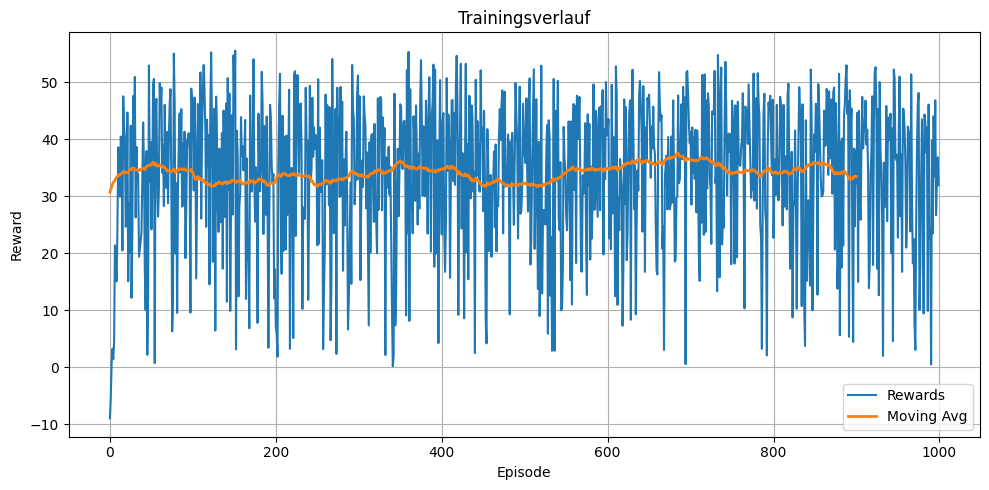

In [4]:
# Trainingsparameter
EPISODES = 1000         # Anzahl Trainingsdurchläufe
MAX_STEPS = 500       # maximale Schritte pro Episode
PLOT_EVERY = 200      # Ausgabefrequenz (nicht kritisch bei wenigen Episoden)

# Umgebung und Agent initialisieren
env = SnakeGame()
agent = DQNAgent()
scores = []  # speichert Rewards pro Episode

# Trainingsloop
for episode in trange(EPISODES, desc="Training"):
    state = env.reset()
    total_reward = 0

    # Spielschleife
    for _ in range(MAX_STEPS):
        # Aktion wählen (ε-greedy)
        action = agent.choose_action(state)

        # Schritt in der Umgebung ausführen
        next_state, reward, done, _ = env.step(action)

        # Erfahrung speichern und Training durchführen
        agent.remember(state, action, reward, next_state, done)
        agent.train_step()

        state = next_state
        total_reward += reward

        if done:
            break  # Spiel ist vorbei

    scores.append(total_reward)

    # Optional: zwischendurch Auswertung anzeigen
    if (episode + 1) % PLOT_EVERY == 0:
        avg = np.mean(scores[-PLOT_EVERY:])
        print(f" Episode {episode+1}, Ø Reward: {avg:.2f}")

# Funktion zum Glätten der Trainingskurve
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode="valid")

# Visualisierung des Trainingsverlaufs
plt.figure(figsize=(10, 5))
plt.plot(scores, label="Rewards")
plt.plot(moving_average(scores), label="Moving Avg", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Trainingsverlauf")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 💾 Modell speichern
Das trainierte Modell wird zur späteren Verwendung gesichert.

In [5]:
agent.save_model("model.pth")
print("Modell gespeichert.")

Modell gespeichert.


## 📊 Evaluation
Bewertung des trainierten Agenten über 50 Testspiele (ε = 0).

 Episode 1 Score: 40.44999999999982
 Episode 2 Score: 45.19999999999974
 Episode 3 Score: 40.89999999999989
 Episode 4 Score: 49.89999999999957
 Episode 5 Score: 59.09999999999928
 Episode 6 Score: 50.24999999999962
 Episode 7 Score: 19.65000000000008
 Episode 8 Score: 39.79999999999978
 Episode 9 Score: 30.550000000000217
 Episode 10 Score: 48.79999999999982
 Episode 11 Score: 52.84999999999939
 Episode 12 Score: 34.45
 Episode 13 Score: 31.35000000000005
 Episode 14 Score: 39.14999999999989
 Episode 15 Score: 37.69999999999991
 Episode 16 Score: 21.750000000000174
 Episode 17 Score: 45.19999999999957
 Episode 18 Score: 15.450000000000031
 Episode 19 Score: 46.999999999999595
 Episode 20 Score: 27.600000000000158
 Episode 21 Score: 39.09999999999994
 Episode 22 Score: 64.74999999999935
 Episode 23 Score: 41.899999999999885
 Episode 24 Score: 52.04999999999952
 Episode 25 Score: 52.7999999999996
 Episode 26 Score: 33.100000000000065
 Episode 27 Score: 21.70000000000009
 Episode 28 Scor

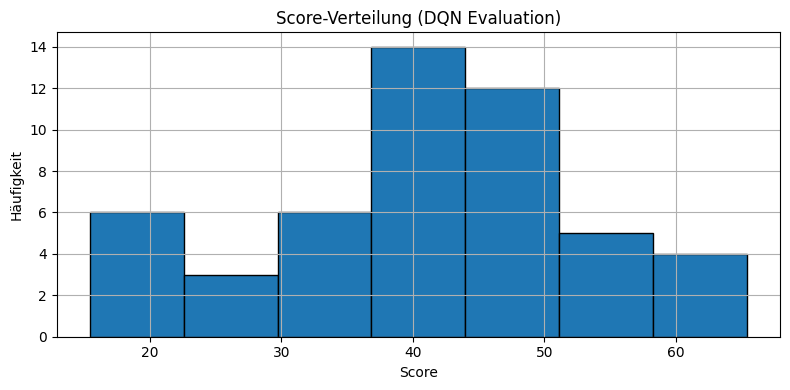

Durchschnittlicher Score: 40.72
Maximaler Score: 65.39999999999867


In [6]:
# Anzahl der Episoden zur Evaluation
NUM_EPISODES = 50

# Keine Exploration mehr → nur noch beste bekannte Aktionen
agent.epsilon = 0

scores = []  # Liste zur Speicherung der Episodenscores

# Evaluation: Der Agent spielt NUM_EPISODES Spiele ohne Lernen
for episode in range(1, NUM_EPISODES + 1):
    state = env.reset()
    total_reward = 0
    done = False

    # Spiel läuft bis zum Ende
    while not done:
        action = agent.choose_action(state)               # beste Aktion wählen
        state, reward, done, _ = env.step(action)         # Schritt ausführen
        total_reward += reward

    scores.append(total_reward)
    print(f" Episode {episode} Score: {total_reward}")

# Visualisierung der Scoreverteilung
plt.figure(figsize=(8, 4))
plt.hist(scores, bins='auto', edgecolor="black")
plt.title("Score-Verteilung (DQN Evaluation)")
plt.xlabel("Score")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.tight_layout()
plt.show()

# Durchschnittliche Leistung anzeigen
print(f"Durchschnittlicher Score: {np.mean(scores):.2f}")
print(f"Maximaler Score: {np.max(scores)}")


## 🎮 Live-Spiel
Zeigt den Agenten beim Spielen in der Pygame-Oberfläche.

In [7]:
# Kein Zufall mehr – Agent handelt nur noch anhand gelernter Policy
agent.epsilon = 0

NUM_GAMES = 1  # Anzahl der Spiele, die live angezeigt werden

# Ausführung mehrerer visueller DQN-Spiele
for i in range(1, NUM_GAMES + 1):
    state = env.reset()
    done = False
    score = 0

    print(f"\n🎮 Spiel {i} startet...")

    while not done:
        # Aktion gemäß gelerntem Modell auswählen
        action = agent.choose_action(state)

        # Aktion ausführen und Zustand aktualisieren
        state, reward, done, _ = env.step(action)
        score += reward

        # Darstellung des Spiels mit pygame
        env.render()

        # kurze Pause für flüssige Animation
        time.sleep(0.1)

    print(f"🏁 Spiel {i} beendet. Score: {score}")
    time.sleep(1)  # Pause zwischen den Spielen



🎮 Spiel 1 startet...
🏁 Spiel 1 beendet. Score: 27.40000000000012
